# Applying `MCube` to the DLPFC data

In [2]:
set.seed(20240709)

max_cores <- 36

library(MCube)
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


In [3]:
RAW_DATA_PATH <- "/import/home/share/zw/data/DLPFC" # H&E images
DATA_PATH <- "/import/home/share/zw/pql/data/DLPFC"
RESULT_PATH <- "/import/home/share/zw/pql/results/DLPFC"

if (!dir.exists(file.path(RESULT_PATH))) {
    dir.create(file.path(RESULT_PATH), recursive = TRUE)
}

In [4]:
# Load in data and cell type deconvolution results

n_slices <- 4
slice_idx_seq <- c(151673, 151674, 151675, 151676)

reference_ST <- data.matrix(
    read.csv(file.path(DATA_PATH, "reference_ST.csv"),
        header = TRUE, row.names = 1, check.names = FALSE
    )
)
dim(reference_ST)
num_celltypes <- nrow(reference_ST)

proportion_ST <- matrix(, nrow = 0, ncol = num_celltypes)
batch_id <- vector("character")
for(i in 1:n_slices){
    proportion_i <- as.matrix(read.csv(
        file.path(
            DATA_PATH,
            paste0("prop_slice", i - 1, ".csv")
        ),
        header = TRUE, row.names = 1, check.names = FALSE
    ))
    proportion_ST <- rbind(proportion_ST, proportion_i)
    batch_id <- c(batch_id, rep(paste0("slice_", slice_idx_seq[i]), nrow(proportion_i)))
}
dim(proportion_ST)
num_spots <- nrow(proportion_ST)
spots <- rownames(proportion_ST)
names(batch_id) <- spots


counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- counts[spots, ]
counts <- data.matrix(counts)
dim(counts)

coordinates <- as.matrix(read.csv(
    file.path(DATA_PATH, "3D_coordinates.csv"),
    header = TRUE, row.names = 1, check.names = FALSE
))
coordinates <- coordinates[spots, ]
dim(coordinates)

spot_effects_ST <- data.matrix(read.csv(
    file.path(DATA_PATH, "spot_effects_ST.csv"),
    header = TRUE, row.names = 1, check.names = FALSE
))[spots, 1]

platform_effects_ST <- data.matrix(read.csv(
    file.path(DATA_PATH, "platform_effects_ST.csv"),
    header = TRUE, row.names = 1, check.names = FALSE
))
rownames(platform_effects_ST) <- paste0("slice_", slice_idx_seq)

library_size_ST <- data.matrix(read.csv(
    file.path(DATA_PATH, "library_size_ST.csv"),
    header = TRUE, row.names = 1, check.names = FALSE
))[spots, 1]

[1]   18 4558

[1] 14243    18

New names:
• `` -> `...1`


Rows: 14243 Columns: 4559
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (4558): A2M, AAK1, AASDHPPT, AASS, AATK, ABCA1, ABCA2, ABCA5, ABCA8, ABC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 14243  4558

[1] 14243     3

## Applying `MCube` to each ST slice seperately

In [ ]:
for (slice_idx in slice_idx_seq) {
    spots_used <- which(batch_id == paste0("slice_", slice_idx))
    mcube_object <- createMCUBE(
        counts = counts[spots_used, ],
        coordinates = coordinates[spots_used, c("x", "y")],
        proportion = proportion_ST[spots_used, ],
        library_size = library_size_ST[spots_used],
        covariates = NULL, batch_id = batch_id[spots_used],
        reference = reference_ST,
        spot_effects = spot_effects_ST[spots_used],
        platform_effects = NULL, # Estimate platform effects automatically in the single slice case
        reference_threshold = 0.5,
        project = paste0("DLPFC_", slice_idx),
    )
    mcube_object <- mcubeFitNull(mcube_object, max_cores = max_cores)
    mcube_object <- mcubeTest(mcube_object, max_cores = max_cores)

    p <- mcubePlotPvalues(mcube_object@pvalues, "combined_pvalue", nrow = 2)
    p <- p +
        labs(title = NULL) +
        theme(
            text = element_text(size = 16),
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16)
        )
    ggsave(
        filename = file.path(
            RESULT_PATH,
            paste0("pvalue_qqplot_", slice_idx, ".png")
        ),
        plot = p, width = 12, height = 7
    )

    saveRDS(
        mcube_object,
        file = file.path(
            RESULT_PATH,
            paste0("mcube_", slice_idx, ".rds")
        )
    )
    # mcube_object <- readRDS(
    #     file = file.path(
    #         RESULT_PATH,
    #         paste0("mcube_", slice_idx, ".rds")
    #     )
    # )

    assign(
        paste0("mcube_object_", slice_idx),
        mcube_object
    )
    rm(mcube_object)
}

mcubeFilterCellTypes: Cell types Astros_1, Astros_2, Endo, Ex_1_L5_6, Ex_3_L4_5, Ex_4_L_6, Ex_6_L4_6, Ex_9_L5_6, Micro/Macro, Oligos_2 have less than the minimum celltype_threshold = 100. To include these cell-types, please reduce the celltype_threshold.

mcubeFilterCellTypes: Cell types Astros_3, Ex_10_L2_4, Ex_2_L5, Ex_5_L5, Ex_7_L4_6, Ex_8_L5_6, Oligos_1, Oligos_3 pass the celltype_threshold = 100.

mcubeFilterGenes: Filter genes based on relative expression with threshold = 5e-05.

The platform effects are not provided and need to be estimated from data!

Preprocessed data description: 3611 spots, 2180 genes, and 18 cell types in total. 3611 spots and 8 cell types to analyze.

Number of cores used: 36.



### Visualization of the deconvolution results of the first slice

In [8]:
slice_idx <- slice_idx_seq[1]
mcube_object <- get(paste0("mcube_object_", slice_idx))

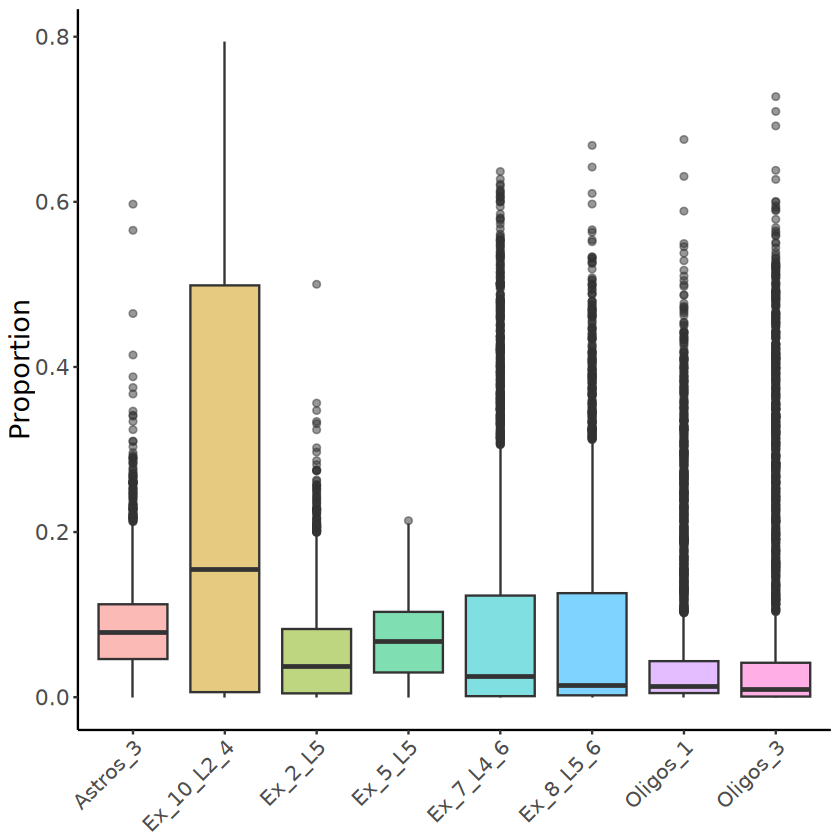

In [9]:
# Proportion
proportion_df <- reshape2::melt(
    mcube_object@proportion[, mcube_object@celltype_test],
    varnames = c("spot", "celltype"), value.name = "proportion"
)

# Boxplot
p <- ggplot(proportion_df, aes(x = celltype, y = proportion)) +
  geom_boxplot(aes(fill = celltype), alpha = 0.5, show.legend = FALSE) +
  theme_classic() +
  labs(title = NULL, x = NULL, y = "Proportion") +
  theme(
    text = element_text(size = 16),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1)
  )
ggsave(
  filename = file.path(RESULT_PATH, "proportion.pdf"),
  plot = p, width = 4, height = 4
)
p

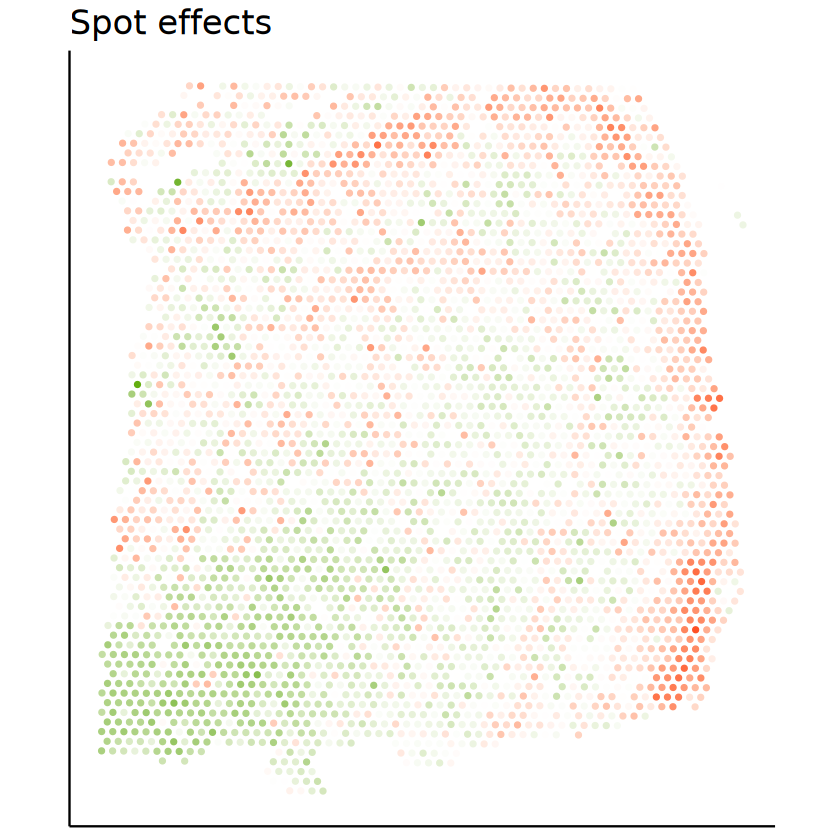

In [14]:
# Spot effects
spot_effects_df <- data.frame(
    x = mcube_object@coordinates[, 1],
    y = mcube_object@coordinates[, 2],
    spot_effect = mcube_object@spot_effects
)

p <- ggplot(spot_effects_df, aes(x = x, y = y, color = spot_effect)) +
  geom_point(size = 1) +
  scale_color_gradient2(
    low = "#64AE11", mid = "white", high = "#FD3000",
    midpoint = median(spot_effects_df$spot_effect)
  ) +
  scale_y_reverse() +
  coord_fixed(ratio = 1) +
  labs(title = "Spot effects", x = NULL, y = NULL) +
  theme_classic() +
  theme(
    plot.title = element_text(size = 20),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "None"
  )

ggsave(
  filename = file.path(RESULT_PATH, "spot_effects.pdf"),
  plot = p, width = 4, height = 4
)
p

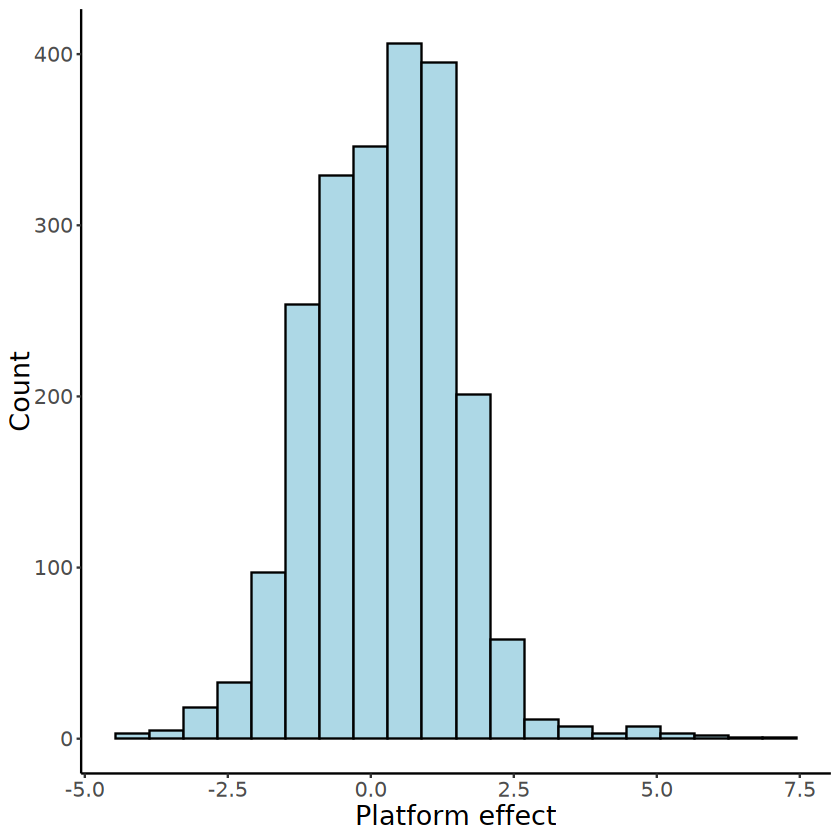

In [15]:
# Platform effects
p <- ggplot(data = NULL, aes(x = platform_effects_ST[1, mcube_object@gene_test])) +
  geom_histogram(bins = 20, fill = "lightblue", color = "black") +
  xlab("Platform effect") +
  ylab("Count") +
  theme_classic() +
  theme(
    text = element_text(size = 16),
    axis.text = element_text(size = 12)
  )
ggsave(
  filename = file.path(RESULT_PATH, "platform_effects.pdf"),
  plot = p, width = 4, height = 4
)
p

In [16]:
rm(mcube_object)

### Visualization of the cell type-specific SVG results

Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 40961 (0xa001) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 65325 (0xff2d) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 65326 (0xff2e) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 65327 (0xff2f) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 65329 (0xff31) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i], :
“TIFFReadDirectory: Unknown field with tag 65330 (0xff32) encountered”
Warning me

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


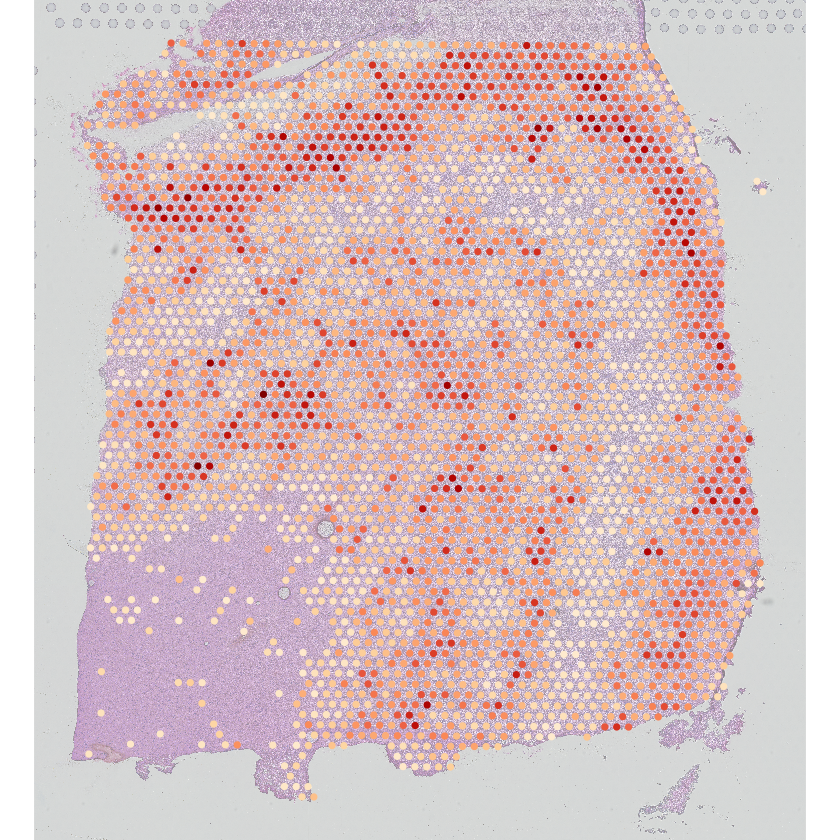

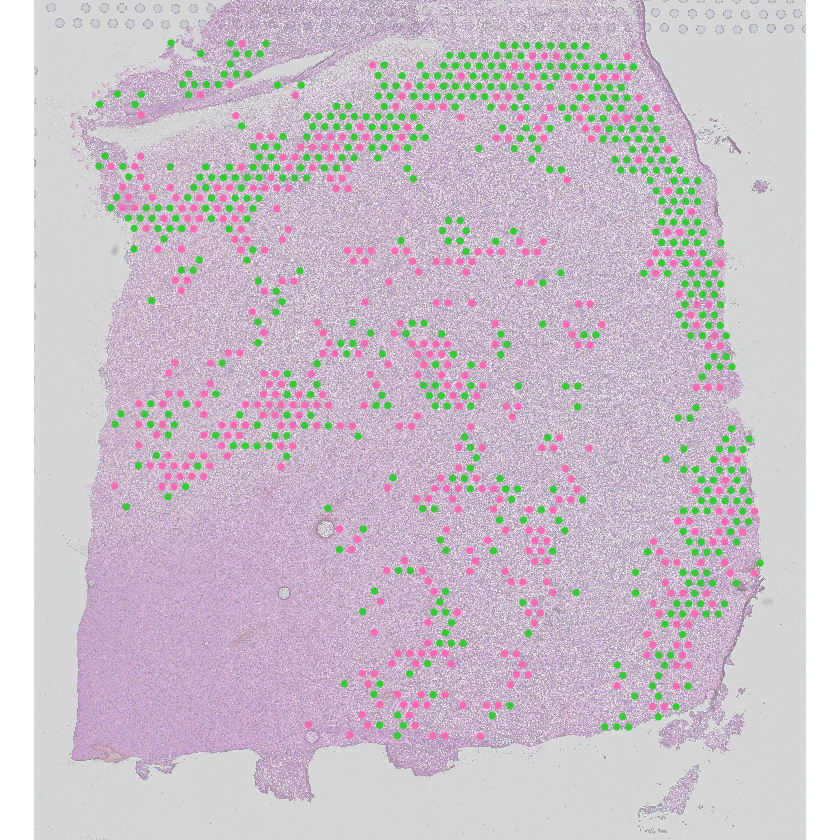

In [6]:
celltype <- "Ex_5_L5"
demo_genes <- c("COX6C", "CAMK2N1", "ENC1", "SYT1")
for(i in 1:slice_idx_seq){
    mcube_object <- get(paste0("mcube_object_", slice_idx_seq[i]))

    # Since STitch3D aligns multiple ST slices, the integrated 3D coordinates cannot match the H&E image
    # Therefore, we use the original 2D coordinates instead
    coordinates_original <- as.matrix(read.csv(
        file.path(DATA_PATH, paste0("2D_coordinates_slice", i - 1, ".csv")),
        header = TRUE, row.names = 1, check.names = FALSE
    ))
    rownames(coordinates_original) <- paste0(rownames(coordinates_original), "-slice", i - 1)
    coordinates_original <- coordinates_original[rownames(mcube_object@proportion), ]

    # Load in H&E image
    he_image <- tiff::readTIFF(
        file.path(
            RAW_DATA_PATH, "spatialLIBD", slice_idx_seq[i],
            paste0(slice_idx_seq[i], "_full_image.tif")
        )
    )
    he_image_0.5 <- array(0.5, dim = c(dim(he_image)[1], dim(he_image)[2], 4))
    he_image_0.5[, , 1] <- he_image[, , 1]
    he_image_0.5[, , 2] <- he_image[, , 2]
    he_image_0.5[, , 3] <- he_image[, , 3]
    # he_image_0.5[, , 4] <- 0.5 

    boader <- 500
    xlim <- c(
        min(coordinates_original[, 1]) - boader, 
        max(coordinates_original[, 1]) + boader
    )
    ylim <- c(
        min(coordinates_original[, 2]) - boader,
        max(coordinates_original[, 2]) + boader
    )

    # Proportion of cell type
    p1 <- mcubePlotPropCellType(
        mcube_object@proportion, coordinates_original, celltype,
        he_image = he_image_0.5[ylim[1]:ylim[2], xlim[1]:xlim[2], ], background = FALSE,
        xlim = xlim, ylim = ylim
    ) +
      scale_x_continuous(limits = xlim, expand = c(0, 0)) +
      scale_y_continuous(trans = "reverse", limits = rev(ylim), expand = c(0, 0)) +
      theme_void() +
      theme(
          plot.title = element_blank(),
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          panel.grid = element_blank(),
          legend.position = "none"
      )
    ggsave(
        filename = file.path(
            RESULT_PATH,
            paste0("proportion_", celltype, "_slice", slice_idx_seq[i], ".png")
        ),
        plot = p1, width = 4, height = 4, bg = "transparent"
    )
    
    # Spatial pattern of SVGs
    for (gene in demo_genes) {
        mcube_object@coordinates <- coordinates_original
        p2 <- mcubePlotExprCellTypeBinary(
            mcube_object,
            celltype = celltype, gene = gene,
            he_image = he_image_0.5[ylim[1]:ylim[2], xlim[1]:xlim[2], ], background = FALSE,
            xlim = xlim, ylim = ylim
        ) +
            scale_x_continuous(limits = xlim, expand = c(0, 0)) +
            scale_y_continuous(trans = "reverse", limits = rev(ylim), expand = c(0, 0)) +
            theme_void() +
            theme(
                plot.title = element_blank(),
                axis.title = element_blank(),
                axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid = element_blank(),
                legend.position = "none"
            )
        ggsave(
            filename = file.path(
                RESULT_PATH,
                paste0(celltype, "_", gene, "_slice", slice_idx_seq[i], ".png")
            ),
            plot = p2, width = 4, height = 4, bg = "transparent"
        )
    }

    rm(mcube_object)
}

p1
p2

## Negative control using one slice

In [ ]:
mcube_object <- get(paste0("mcube_object_", slice_idx_seq[1]))

shuffle_idx <- sample(
    1:nrow(mcube_object@coordinates),
    nrow(mcube_object@coordinates)
)
write.csv(shuffle_idx, file = file.path(DATA_PATH, "shuffle_idx.csv"), row.names = FALSE)
shuffle_idx <- read.csv(file.path(DATA_PATH, "shuffle_idx.csv"), header = TRUE)[, 1]
length(unique(shuffle_idx))

coordinates_shuffle <- mcube_object@coordinates[shuffle_idx, ]
rownames(coordinates_shuffle) <- rownames(mcube_object@coordinates)
write.csv(coordinates_shuffle, file = file.path(DATA_PATH, "coordinates_shuffle.csv"))
coordinates_shuffle <- data.matrix(read.csv(
    file.path(DATA_PATH, "coordinates_shuffle.csv"),
    header = TRUE, row.names = 1, check.names = FALSE
))

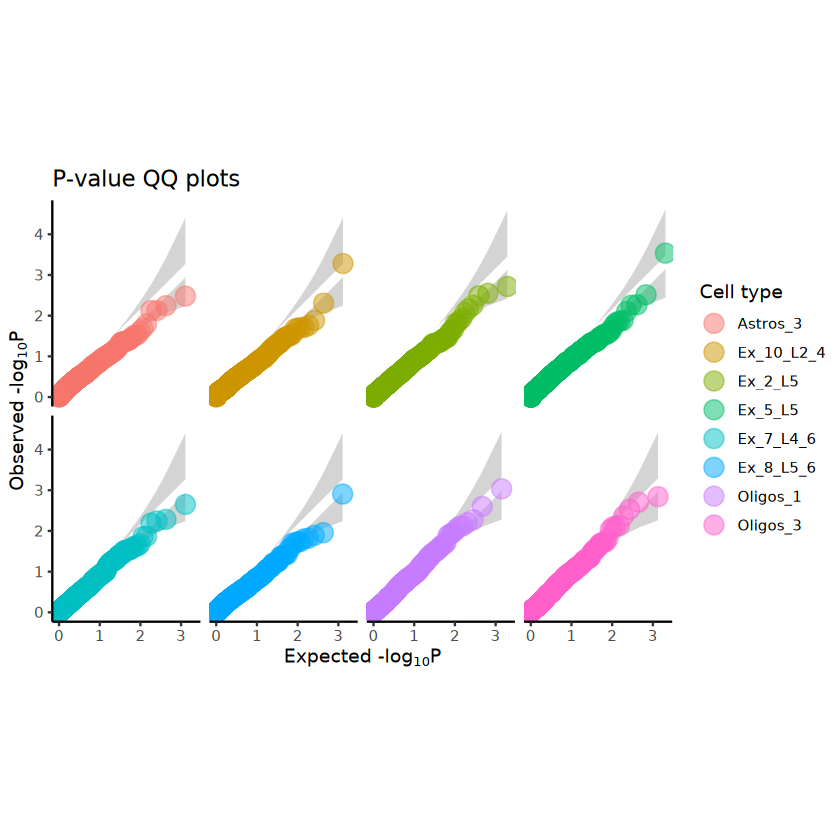

In [9]:
mcube_object_null <- mcube_object
rm(mcube_object)

mcube_object_null@coordinates <- coordinates_shuffle
mcube_object_null <- mcubeFitNull(mcube_object_null, max_cores = max_cores)
mcube_object_null <- mcubeTest(mcube_object_null, max_cores = max_cores)

pvalues_null <- mcube_object_null@pvalues
rm(mcube_object_null)

p <- mcubePlotPvalues(
    pvalues_null, "combined_pvalue",
    nrow = 2, under_null = TRUE
)
ggsave(
    filename = file.path(
        RESULT_PATH,
        paste0("pvalue_qqplot_null_", slice_idx_seq[1], ".png")
    ),
    plot = p, width = 12, height = 7
)
p

saveRDS(
    pvalues_null,
    file = file.path(
        RESULT_PATH,
        paste0("pvalues_", slice_idx_seq[1], "_null.rds")
    )
)
# pvalues_null <- readRDS(
#     file = file.path(
#         RESULT_PATH,
#         paste0("pvalues_", slice_idx_seq[1], "_null.rds")
#     )
# )

In [10]:
rm(list = ls(pattern = "mcube_object_"))

## Applying `MCube` to the integrated four ST slices together

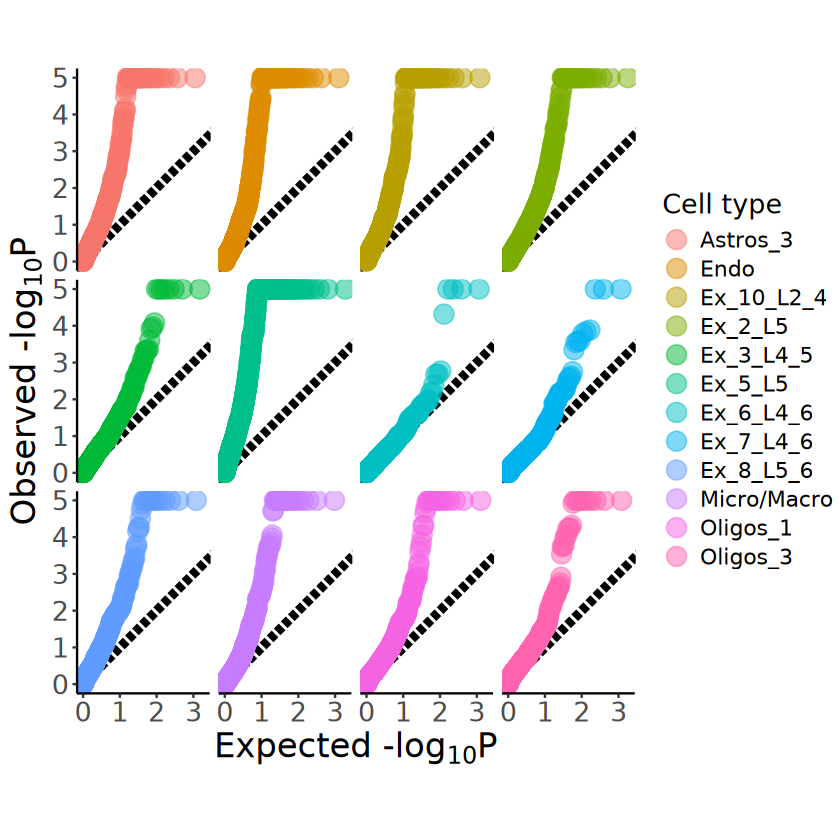

In [ ]:
mcube_object_all <- createMCUBE(
    counts = counts, coordinates = coordinates, 
    proportion = proportion_ST, library_size = library_size_ST, 
    covariates = NULL, batch_id = batch_id,
    reference = reference_ST,
    spot_effects = spot_effects_ST, platform_effects = platform_effects_ST,
    project = "DLPFC_all"
)
mcube_object_all <- mcubeFitNull(mcube_object_all, max_cores = max_cores)
mcube_object_all <- mcubeTest(mcube_object_all, max_cores = max_cores)

p <- mcubePlotPvalues(mcube_object_all@pvalues, "combined_pvalue", nrow = 3) +
    labs(title = NULL) +
    theme(
        text = element_text(size = 16),
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16)
    )
ggsave(
    filename = file.path(
        RESULT_PATH,
        paste0("pvalue_qqplot_all.png")
    ),
    plot = p, width = 12, height = 12
)
p

saveRDS(
    mcube_object_all,
    file = file.path(
        RESULT_PATH,
        paste0("mcube_all", ".rds")
    )
)
# mcube_object_all <- readRDS(
#     file = file.path(
#         RESULT_PATH,
#         paste0("mcube_all", ".rds")
#     )
# )

### Visualization of the cell type-specific SVG results from the 3D perspective

In [14]:
# For visualization
mcube_object_all@coordinates[, "x"] = -mcube_object_all@coordinates[, "x"]
mcube_object_all@coordinates[, "z"] = (mcube_object_all@coordinates[, "z"] -
    (mcube_object_all@coordinates[, "z"] > 14) * 397.3) * 200
mcube_object_all@coordinates[, "x"] = mcube_object_all@coordinates[, "x"] / 1.37
mcube_object_all@coordinates[, "y"] = mcube_object_all@coordinates[, "y"] / 1.37
mcube_object_all@coordinates[, "z"] = mcube_object_all@coordinates[, "z"] / 1.37

In [7]:
celltype <- "Ex_5_L5"
demo_genes <- c("COX6C", "CAMK2N1", "ENC1", "SYT1")
for (gene in demo_genes) {
    p <- mcubePlotExprCellType3D(
        mcube_object_all, celltype, gene,
        spot_size = 1.5, opacity_target = 0.7, opacity_background = 0.1,
        plotly_eye = list(x = -0.9, y = 1.7, z = 1.2)
    )
    plotly::save_image(
        p, file.path(RESULT_PATH, paste0(celltype, "_", gene, "_3D", ".pdf")),
        width = 500, height = 500, scale = 5
    )
}

### Visualization of the platform effects across slices

In [15]:
demo_genes <- c("COX6C", "CAMK2N1", "SYT1")
n_slices <- 4
n_genes <- 3
platform_effects_demo_gene <- data.frame(
    slice = rep(paste("Slice", slice_idx_seq), n_genes),
    gene = rep(demo_genes, each = n_slices),
    platform_effect = as.vector(platform_effects_ST[, demo_genes])
)
platform_effects_demo_gene$gene <- factor(
    platform_effects_demo_gene$gene,
    levels = demo_genes
)

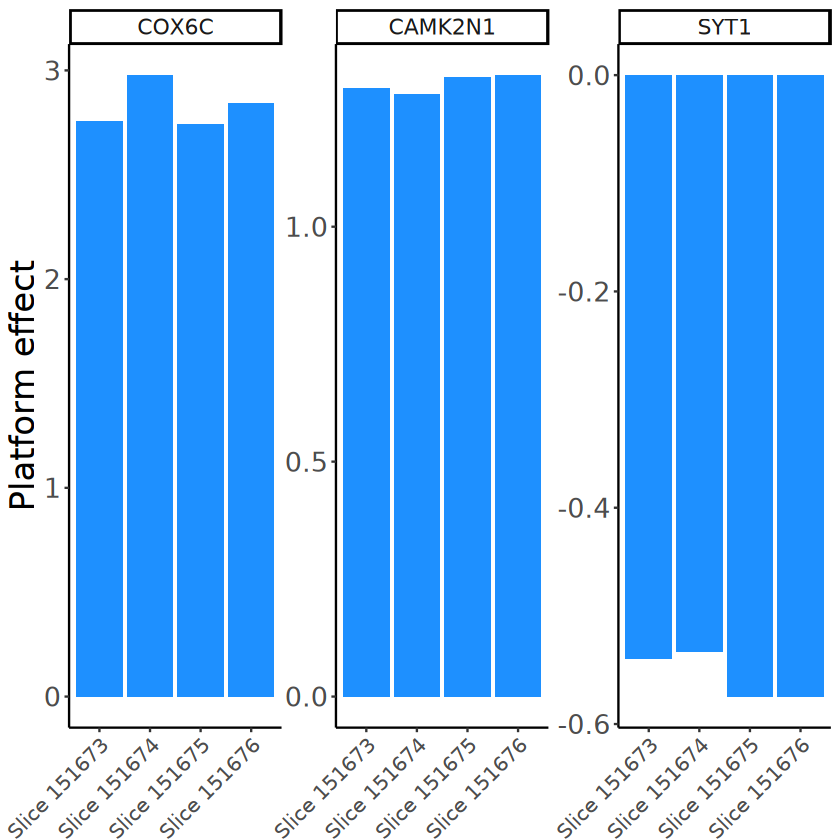

In [16]:
p <- ggplot(
    data = platform_effects_demo_gene,
    aes(x = slice, y = platform_effect)
) +
    geom_bar(stat = "identity", fill = "dodgerblue") +
    labs(x = NULL, y = "Platform effect") +
    facet_wrap(.~gene, nrow = 1, scales = "free_y") +
    theme_classic() +
    theme(
        text = element_text(size = 16),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 16),
        strip.text = element_text(face = "italic")
    )
ggsave(
    filename = file.path(
        RESULT_PATH,
        paste0(
            "batch_effects",
            ".pdf"
        )
    ),
    plot = p, width = 10, height = 4
)
p

## Comparison of the 2D and 3D results

In [15]:
celltype <- "Ex_5_L5"
for (i in 1:n_slices) {
    assign(
        paste0("svg_list_", i),
        mcubeGetSigGenes(get(paste0("mcube_object_", slice_idx_seq[i]))@pvalues)[[celltype]]
    )
}
svg_list_all <- mcubeGetSigGenes(mcube_object_all@pvalues)[[celltype]]

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.



mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.



In [24]:
svg_list <- list(
    All_slices = rownames(svg_list_all),
    Slice_1 = rownames(svg_list_1),
    Slice_2 = rownames(svg_list_2),
    Slice_3 = rownames(svg_list_3),
    Slice_4 = rownames(svg_list_4)
)
names(svg_list) <- c("All slices", paste("Slice", slice_idx_seq))

In [27]:
all_genes <- unique(unlist(svg_list))
svg_mat <- matrix(FALSE, nrow = length(all_genes), ncol = length(svg_list))
rownames(svg_mat) <- all_genes
colnames(svg_mat) <- names(svg_list)

for (i in 1:length(svg_list)) {
    svg_mat[svg_list[[i]], i] <- TRUE
}
head(svg_mat)

All slices Slice 151673 Slice 151674 Slice 151675 Slice 151676
COX6C   TRUE       TRUE         TRUE         TRUE         TRUE        
CAMK2N1 TRUE       TRUE         TRUE         TRUE         TRUE        
TUBA1B  TRUE       TRUE         TRUE         TRUE         TRUE        
ENC1    TRUE       TRUE         TRUE         TRUE         TRUE        
SYT1    TRUE       TRUE         TRUE         TRUE         TRUE        
TMSB10  TRUE       TRUE         TRUE         TRUE         TRUE

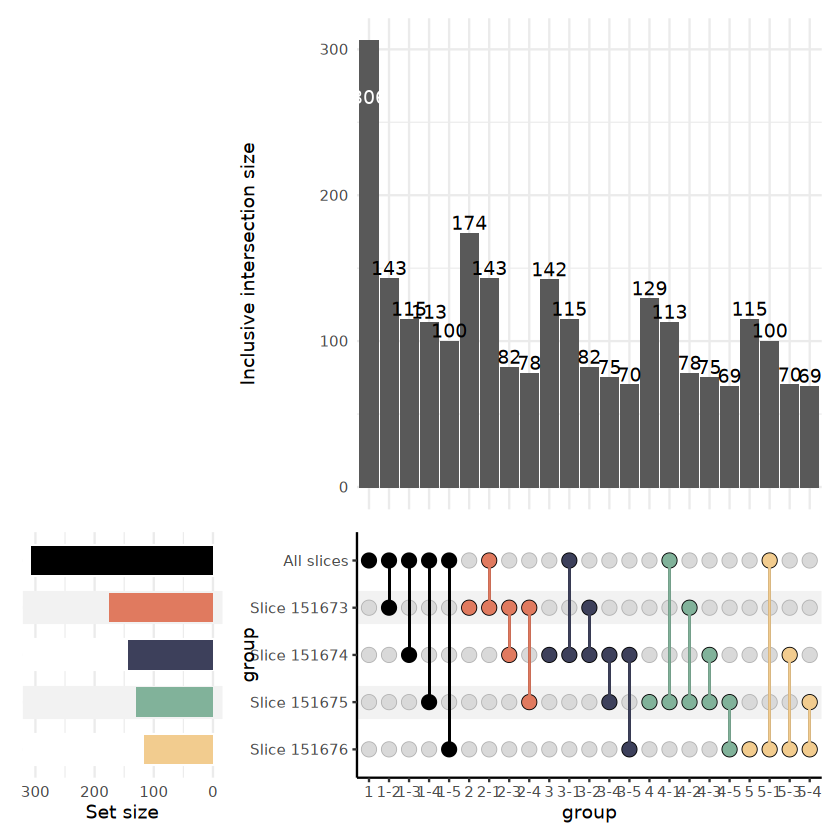

In [36]:
# "#e07a5f","#3d405b","#81b29a","#f2cc8f"
p <- ComplexUpset::upset(
    data = as.data.frame(svg_mat),
    intersect = rev(colnames(svg_mat)),
    max_degree = 2,
    sort_sets = FALSE,
    group_by = "sets",
    mode = 'inclusive_intersection',
    queries = list(
        upset_query(group = names(svg_list)[1], color = "black"),
        upset_query(group = names(svg_list)[2], color = "#e07a5f"),
        upset_query(group = names(svg_list)[3], color = "#3d405b"),
        upset_query(group = names(svg_list)[4], color = "#81b29a"),
        upset_query(group = names(svg_list)[5], color = "#f2cc8f"),
        upset_query(set = names(svg_list)[1], fill = "black"),
        upset_query(set = names(svg_list)[2], fill = "#e07a5f"),
        upset_query(set = names(svg_list)[3], fill = "#3d405b"),
        upset_query(set = names(svg_list)[4], fill = "#81b29a"),
        upset_query(set = names(svg_list)[5], fill = "#f2cc8f")
    )
) + theme_classic()
ggsave(
    file.path(RESULT_PATH, "upset.pdf"),
    plot = p, width = 10, height = 6
)
p